# Workshop 2023.01 : Performance de l'enveloppe <a class="tocSkip">

*Sarah Juricic & Simon Rouchier*

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-&amp;-look-at-data" data-toc-modified-id="Load-&amp;-look-at-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load &amp; look at data</a></span></li><li><span><a href="#Regression-with-statsmodels" data-toc-modified-id="Regression-with-statsmodels-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regression with statsmodels</a></span><ul class="toc-item"><li><span><a href="#Bilinear-model" data-toc-modified-id="Bilinear-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Bilinear model</a></span></li><li><span><a href="#Residuals" data-toc-modified-id="Residuals-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Residuals</a></span></li></ul></li><li><span><a href="#Regression-with-pymc3" data-toc-modified-id="Regression-with-pymc3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Regression with pymc3</a></span><ul class="toc-item"><li><span><a href="#Diagnostic-of-success" data-toc-modified-id="Diagnostic-of-success-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Diagnostic of success</a></span></li></ul></li></ul></div>

# Load & look at data

Always look at data...

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("data/simulated_coheating_data_eff1.csv",
                 parse_dates=['index'],
                 index_col='index')

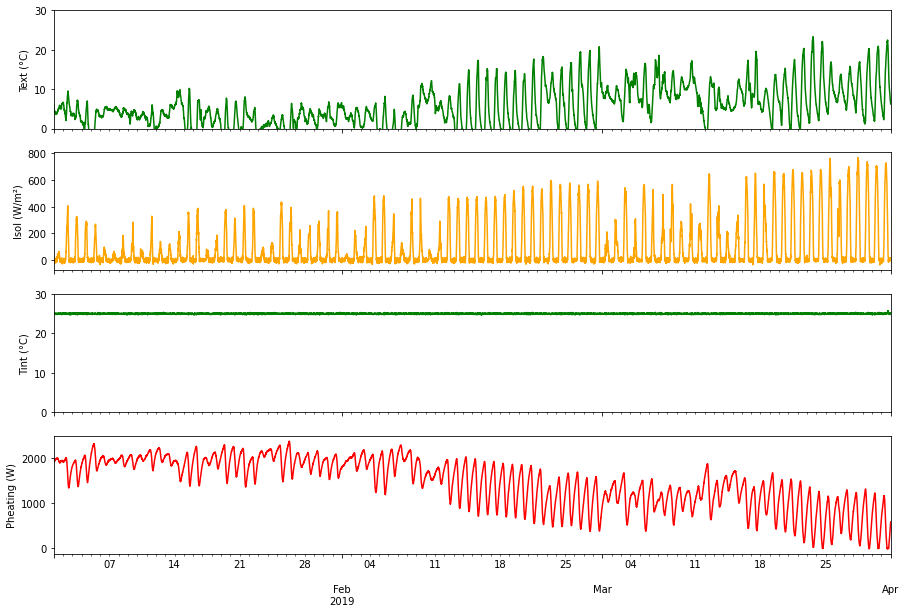

In [3]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(15,10))

df['Text'].plot(ax=ax[0], color='green', ylabel='Text (°C)', ylim=[0,30])
df['Isol'].plot(ax=ax[1], color='orange', ylabel='Isol (W/m²)')
df['Tint'].plot(ax=ax[2], color='green', ylabel='Tint (°C)', ylim=[0, 30])
df['Ph'].plot(ax=ax[3], color='red', ylabel='Pheating (W)', xlabel='');

We define $\Delta T=T_{int} - T_{ext}$

In [4]:
df['ΔT'] = df['Tint'] - df['Text']

We truncate the data as to keep February only.

In [5]:
test_start = pd.Timestamp("2019-02-01 06:00")
test_end = pd.Timestamp("2019-03-01 05:59")
feb_data = df.truncate(before=test_start, after=test_end)

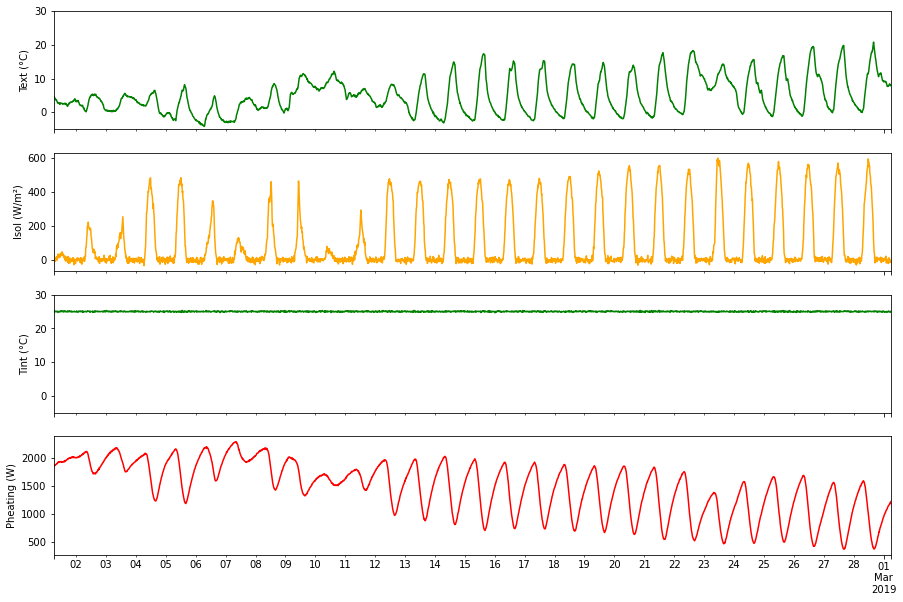

In [6]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(15,10))

feb_data['Text'].plot(ax=ax[0], color='green', ylabel='Text (°C)', ylim=[-5,30])
feb_data['Isol'].plot(ax=ax[1], color='orange', ylabel='Isol (W/m²)')
feb_data['Tint'].plot(ax=ax[2], color='green', ylabel='Tint (°C)', ylim=[-5, 30])
feb_data['Ph'].plot(ax=ax[3], color='red', ylabel='Pheating (W)', xlabel='');

We make a daily average (6 am -- 6 am) from the February data.

In [7]:
daily_data = feb_data.resample('1D', origin=test_start).mean()

Let's look at the data is see if a regression is physically appropriate.

<AxesSubplot:xlabel='ΔT', ylabel='Ph'>

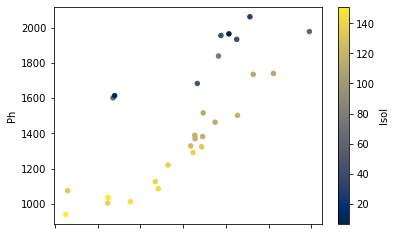

In [8]:
daily_data.plot.scatter("ΔT", 'Ph', c='Isol', cmap="cividis")

# Regression with statsmodels

Model 1 : $P_{heating}=HTC \times (T_{int} - T_{ext}) - \alpha I_{sol} + \epsilon = HTC \times \Delta T - \alpha I_{sol} + \epsilon$

Model 1 is a bi-linear model, with two "input" exogeneous variables $\Delta T$ and $I_{sol}$ and one "output" endogeneous variable $P_{heating}$.

We use the statsmodels library to povide a leastsquare bilinear regression of this model. We import OLS (Ordinary Least Squares).

In [9]:
from statsmodels.api import OLS

## Bilinear model

First, we copy the coehating data as numpy arrays.

In [10]:
endog = daily_data['Ph'].values
exog = np.concatenate([[daily_data['ΔT'].values], [daily_data['Isol'].values]]).T

We create an oridnary least square models as follows, and fit it straight away.

In [11]:
mls_unbiased = OLS(endog=endog, exog=exog).fit()

In [12]:
mls_unbiased.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.994   
Dependent Variable:     y                AIC:                         347.2748
Date:                   2023-03-13 08:19 BIC:                         349.9392
No. Observations:       28               Log-Likelihood:              -171.64 
Df Model:               2                F-statistic:                 2381.   
Df Residuals:           26               Prob (F-statistic):          3.58e-30
R-squared (uncentered): 0.995            Scale:                       13307.  
-----------------------------------------------------------------------------------
            Coef.       Std.Err.         t         P>|t|        [0.025       0.975]
-----------------------------------------------------------------------------------
x1         91.6299        2.3200      39.4953      0.0000      86.8610      96.3987
x2         -3.7901        0.4273      -8.8697      0.0000      -4.6685      -2.9118
------------------------------------------------------------------------------
Omnibus:                   6.207            Durbin-Watson:               1.250
Prob(Omnibus):             0.045            Jarque-Bera (JB):            4.793
Skew:                      0.996            Prob(JB):                    0.091
Kurtosis:                  3.369            Condition No.:               12   
==============================================================================

"""

In [13]:
HTC = mls_unbiased.params[0]

What we want to look at :

- R² : pearson coefficient
- estimated values : x1 is the HTC, x2 \alpha
    - look at their estimated values, their standard error, their p-value (should be under 0,05)
- and the other statistics:
    - Omnibus (Χ² test) and its two-tail probability prob(omni)
    - skew
    - kurtosis
    - Drubin-Watson
    - Jarque-Bera and its 
    - condition number : 

## Residuals

Let us have a look at the residuals.

In [14]:
import statsmodels.api as sm

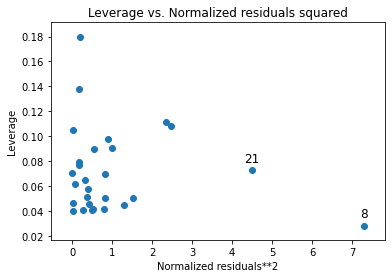

In [15]:
sm.graphics.plot_leverage_resid2(mls_unbiased);

Let us also plot the auto-correlation of the residuals.

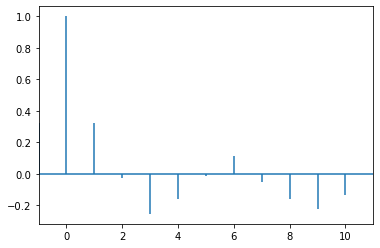

In [16]:
plt.xlim(-1,11)
plt.acorr(mls_unbiased.resid);

# Regression with pymc3

In [17]:
import pymc3 as pm

ModuleNotFoundError: No module named 'pymc3'

We define the same model in a Bayesian approach.

In [ ]:
with pm.Model() as bilin_model:
    
    # first define the prior of the unknown
    # we suppose HTC and α are normal
    HTC = pm.Normal('HTC', mu=100, sigma=30)  # HTC around 100 with a very large uncertainty
    alpha = pm.Normal('α', mu=5, sigma=2)  # α takes usually values between 0 and 10...
    
    # let us define the prediction i.e. the predicted heating if we knew only ΔT and Isol
    predicted_Ph = HTC * daily_data['ΔT'] - alpha * daily_data['Isol']
    
    # and now the observed heating power, with an error ϵ
    epsilon = pm.Normal('ϵ', mu=10, sigma=50)  # we assume a normal error with a possibly large variance
    obs = pm.Normal('obs', mu=predicted_Ph, sigma=epsilon, observed=daily_data['Ph'])

In [ ]:
with bilin_model:
    trace = pm.sample(2000, tune = 1000, chains=4, cores=2, return_inferencedata=True)

## Diagnostic of success

In [ ]:
import arviz as az

The summary gives some indication of the success of the sampling :
- high ess values (over a few thousand)
- r_hat at 1.0 (should be < 1.05)

In [ ]:
az.summary(trace)

The traces look fine, the four chains are in agreement with each other.

In [ ]:
az.plot_trace(trace);

The pair plot reveals a correlation between HTC and α

In [ ]:
az.plot_pair(
    trace,
    textsize=10,
    figsize=(8,6)
)